
# Convolutional Neural Networks (CNN)

## Project: Write an Algorithm for a Dog Identification App 



---
### Why We're Here 

In this notebook, I will make the first steps towards developing an algorithm that could be used as part of a mobile or web app.  At the end of this project, our code will accept any user-supplied image as input.  If a dog is detected in the image, it will provide an estimate of the dog's breed.  If a human is detected, it will provide an estimate of the dog breed that is most resembling. The image below displays potential sample output of our finished project. 

![Sample Dog Output](images/sample_dog_output.png)

In this real-world setting, we will need to piece together a series of models to perform different tasks; for instance, the algorithm that detects humans in an image will be different from the CNN that infers dog breed.  There are many points of possible failure, and no perfect algorithm exists.  Our imperfect solution will nonetheless create a fun user experience!

### The Road Ahead

We break the notebook into separate steps.  Feel free to use the links below to navigate the notebook.

* [Step 0](#step0): Import Datasets
* [Step 1](#step1): Detect Humans
* [Step 2](#step2): Detect Dogs
* [Step 3](#step3): Create a CNN to Classify Dog Breeds (from Scratch)
* [Step 4](#step4): Use a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 5](#step5): Create a CNN to Classify Dog Breeds (using Transfer Learning)
* [Step 6](#step6): Write the Algorithm
* [Step 7](#step7): Test the Algorithm

---
<a id='step0'></a>
## Step 0: Import Datasets

### Import Dog Dataset

In the code cell below, we import a dataset of dog images.  We populate a few variables through the use of the `load_files` function from the scikit-learn library:
- `train_files`, `valid_files`, `test_files` - numpy arrays containing file paths to images
- `train_targets`, `valid_targets`, `test_targets` - numpy arrays containing onehot-encoded classification labels 
- `dog_names` - list of string-valued dog breed names for translating labels

In [1]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


### Import Human Dataset

In the code cell below, we import a dataset of human images, where the file paths are stored in the numpy array `human_files`.

In [2]:
import random
random.seed(8675309)

# load filenames in shuffled human dataset
human_files = np.array(glob("lfw/lfw/*/*"))
random.shuffle(human_files)

# print statistics about the dataset
print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


---
<a id='step1'></a>
## Step 1: Detect Humans

We use OpenCV's implementation of [Haar feature-based cascade classifiers](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) to detect human faces in images.  OpenCV provides many pre-trained face detectors, stored as XML files on [github](https://github.com/opencv/opencv/tree/master/data/haarcascades).  We have downloaded one of these detectors and stored it in the `haarcascades` directory.

In the next code cell, we demonstrate how to use this detector to find human faces in a sample image.

Number of faces detected: 1


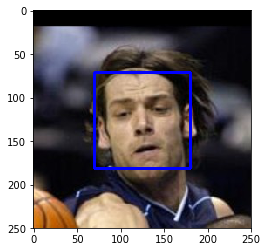

In [3]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[8])

# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Before using any of the face detectors, it is standard procedure to convert the images to grayscale.  The `detectMultiScale` function executes the classifier stored in `face_cascade` and takes the grayscale image as a parameter.  

In the above code, `faces` is a numpy array of detected faces, where each row corresponds to a detected face.  Each detected face is a 1D array with four entries that specifies the bounding box of the detected face.  The first two entries in the array (extracted in the above code as `x` and `y`) specify the horizontal and vertical positions of the top left corner of the bounding box.  The last two entries in the array (extracted here as `w` and `h`) specify the width and height of the box.

### Write a Human Face Detector

We can use this procedure to write a function that returns `True` if a human face is detected in an image and `False` otherwise.  This function, aptly named `face_detector`, takes a string-valued file path to an image as input and appears in the code block below.

In [4]:
# returns "True" if face is detected in image stored at img_path
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

###  Assess the Human Face Detector

Now we will test the performance of the `face_detector` function to see: 

- What percentage of the first 100 images in `human_files` have a detected human face?  
- What percentage of the first 100 images in `dog_files` have a detected human face? 

Ideally, we would like 100% of human images with a detected face and 0% of dog images with a detected face.  We will see that our algorithm falls short of this goal, but still gives acceptable performance.  We extract the file paths for the first 100 images from each of the datasets and store them in the numpy arrays `human_files_short` and `dog_files_short`.


Percentage of humans correctly classified as people: 99.0%
Percentage of dogs misclassified as people: 11.0%
missclassified humans and dogs:


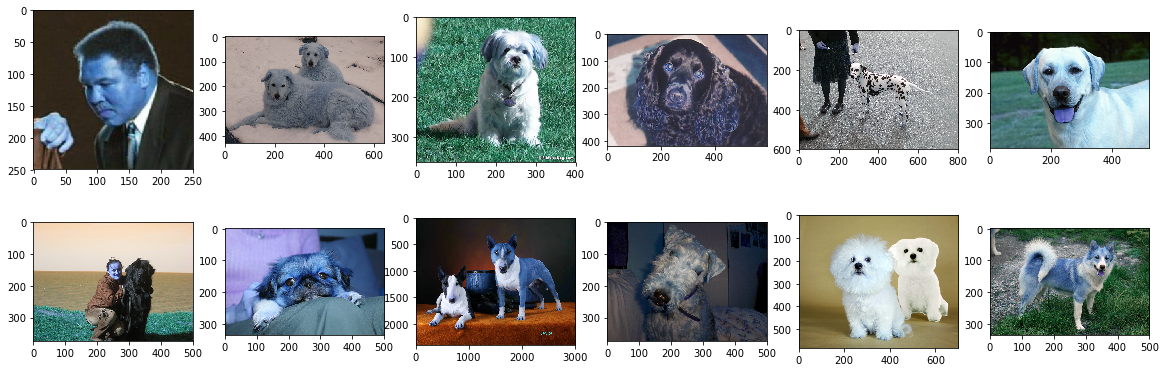

In [5]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

human_count = 0
miss_human = []
total = 0
for img in human_files_short:
    human_check = face_detector(img)
    if not human_check:
        human_count += 1
        total = 100 - human_count
        miss_human.append(img)
    percentage = (total/len(human_files_short)) * 100
print('Percentage of humans correctly classified as people: {}%'.format(percentage))

dog_count = 0
miss_dog = []
for img in dog_files_short:
    human_check = face_detector(img)
    if human_check:
        dog_count += 1
        miss_dog.append(img)     
    percentage = (dog_count/len(dog_files_short)) * 100
print('Percentage of dogs misclassified as people: {}%'.format(percentage))


print ('missclassified humans and dogs:')
plt.figure(figsize=(20,10))
columns = 6
images = list(miss_human)+list(miss_dog)
for i, image in enumerate(images):
    image = cv2.imread(image)
    plt.subplot(len(images) / columns + 1, columns, i + 1)
    plt.imshow(image)


This algorithmic choice necessitates that we communicate to the user that we accept human images only when they provide a clear view of a face (otherwise, we risk having unneccessarily frustrated users!). This seems to be a reasonable approach to clearly communicate the pitfalls of our application to the user to justify his/her expectations, also, it may be offensive to some people to be missclassified as dogs! (or disrespectful to dogs to be missclassified as humans? you never know!)

The [Haar cascade classifier](http://docs.opencv.org/trunk/d7/d8b/tutorial_py_face_detection.html) is based on Adaboost, that is, it uses an ensemble of weak learners weighted differently to come up with the final prediction. One way to improve this algorithm is to use [data augmentation](https://arxiv.org/pdf/1609.08764.pdf) to improve our training set and add to the variation of our images. However, this will not terminate the possibility of missclassification and it's always the best approach to let the user now about this ahead of time. 



---
<a id='step2'></a>
## Step 2: Detect Dogs

In this section, we use a pre-trained [ResNet-50](http://ethereon.github.io/netscope/#/gist/db945b393d40bfa26006) model to detect dogs in images.  Our first line of code downloads the ResNet-50 model, along with weights that have been trained on [ImageNet](http://www.image-net.org/), a very large, very popular dataset used for image classification and other vision tasks.  ImageNet contains over 10 million URLs, each linking to an image containing an object from one of [1000 categories](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a).  Given an image, this pre-trained ResNet-50 model returns a prediction (derived from the available categories in ImageNet) for the object that is contained in the image.

In [6]:
from keras.applications.resnet50 import ResNet50
# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')

### Pre-process the Data

When using TensorFlow as backend, Keras CNNs require a 4D array (which we'll also refer to as a 4D tensor) as input, with shape

$$
(\text{nb_samples}, \text{rows}, \text{columns}, \text{channels}),
$$

where `nb_samples` corresponds to the total number of images (or samples), and `rows`, `columns`, and `channels` correspond to the number of rows, columns, and channels for each image, respectively.  

The `path_to_tensor` function below takes a string-valued file path to a color image as input and returns a 4D tensor suitable for supplying to a Keras CNN.  The function first loads the image and resizes it to a square image that is $224 \times 224$ pixels.  Next, the image is converted to an array, which is then resized to a 4D tensor.  In this case, since we are working with color images, each image has three channels.  Likewise, since we are processing a single image (or sample), the returned tensor will always have shape

$$
(1, 224, 224, 3).
$$

The `paths_to_tensor` function takes a numpy array of string-valued image paths as input and returns a 4D tensor with shape 

$$
(\text{nb_samples}, 224, 224, 3).
$$

Here, `nb_samples` is the number of samples, or number of images, in the supplied array of image paths.  It is best to think of `nb_samples` as the number of 3D tensors (where each 3D tensor corresponds to a different image) in your dataset!

In [12]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

### Making Predictions with ResNet-50

Getting the 4D tensor ready for ResNet-50, and for any other pre-trained model in Keras, requires some additional processing.  First, the RGB image is converted to BGR by reordering the channels.  All pre-trained models have the additional normalization step that the mean pixel (expressed in RGB as $[103.939, 116.779, 123.68]$ and calculated from all pixels in all images in ImageNet) must be subtracted from every pixel in each image.  This is implemented in the imported function `preprocess_input`.  If you're curious, you can check the code for `preprocess_input` [here](https://github.com/fchollet/keras/blob/master/keras/applications/imagenet_utils.py).

Now that we have a way to format our image for supplying to ResNet-50, we are now ready to use the model to extract the predictions.  This is accomplished with the `predict` method, which returns an array whose $i$-th entry is the model's predicted probability that the image belongs to the $i$-th ImageNet category.  This is implemented in the `ResNet50_predict_labels` function below.

By taking the argmax of the predicted probability vector, we obtain an integer corresponding to the model's predicted object class, which we can identify with an object category through the use of this [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a). 

In [9]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

### Write a Dog Detector

While looking at the [dictionary](https://gist.github.com/yrevar/942d3a0ac09ec9e5eb3a), we will notice that the categories corresponding to dogs appear in an uninterrupted sequence and correspond to dictionary keys 151-268, inclusive, to include all categories from `'Chihuahua'` to `'Mexican hairless'`.  Thus, in order to check to see if an image is predicted to contain a dog by the pre-trained ResNet-50 model, we need only check if the `ResNet50_predict_labels` function above returns a value between 151 and 268 (inclusive).

We use these ideas to complete the `dog_detector` function below, which returns `True` if a dog is detected in an image (and `False` if not).

In [10]:
### returns "True" if a dog is detected in the image stored at img_path
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

### Assess the Dog Detector

We will now use the code cell below to test the performance of your `dog_detector` function.  
- What percentage of the images in `human_files_short` have a detected dog?  
- What percentage of the images in `dog_files_short` have a detected dog?


Percentage of humans misclassified as dogs:: 1.0%
Percentage of dogs correctly classified as dogs: 100.0%


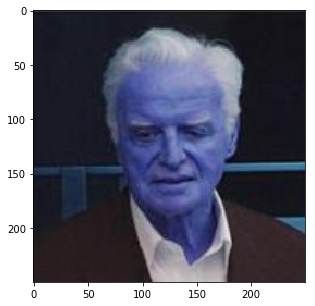

In [11]:
### Test the performance of the dog_detector function
### on the images in human_files_short and dog_files_short.
human_count = 0    
miss_human = []
for img in human_files_short:
    dog_check = dog_detector(img)
    if dog_check:
        human_count += 1
        miss_human.append(img)
    percentage = (human_count/len(human_files_short)) * 100
print('Percentage of humans misclassified as dogs:: {}%'.format(percentage))

dog_count = 0
for img in dog_files_short:
    dog_check = dog_detector(img)
    if dog_check:
        dog_count += 1
    percentage = (dog_count/len(dog_files_short)) * 100
print('Percentage of dogs correctly classified as dogs: {}%'.format(percentage))

plt.figure(figsize=(5,5))
image = cv2.imread(miss_human[0])
plt.subplot(1,1,1)
plt.imshow(image)

---
<a id='step3'></a>
## Step 3: Create a CNN to Classify Dog Breeds (from Scratch)

Now that we have functions for detecting humans and dogs in images, we need a way to predict breed from images.  In this step, we will create a CNN that classifies dog breeds.  We must create our CNN _from scratch_ , and we must attain a test accuracy of at least 1%.  In Step 5 of this notebook, we will have the opportunity to use transfer learning to create a CNN that attains greatly improved accuracy.

We should be careful with adding too many trainable layers. More parameters means longer training, which means we are more likely to need a GPU to accelerate the training process.  Thankfully, Keras provides a handy estimate of the time that each epoch is likely to take; we can extrapolate this estimate to figure out how long it will take for our algorithm to train. 

We mention that the task of assigning breed to dogs from images is considered exceptionally challenging.  To see why, consider that *even a human* would have great difficulty in distinguishing between a Brittany and a Welsh Springer Spaniel.  

Brittany | Welsh Springer Spaniel
- | - 
<img src="images/Brittany_02625.jpg" width="100"> | <img src="images/Welsh_springer_spaniel_08203.jpg" width="200">

It is not difficult to find other dog breed pairs with minimal inter-class variation (for instance, Curly-Coated Retrievers and American Water Spaniels).  

Curly-Coated Retriever | American Water Spaniel
- | -
<img src="images/Curly-coated_retriever_03896.jpg" width="200"> | <img src="images/American_water_spaniel_00648.jpg" width="200">


Likewise, recall that labradors come in yellow, chocolate, and black.  Our vision-based algorithm will have to conquer this high intra-class variation to determine how to classify all of these different shades as the same breed.  

Yellow Labrador | Chocolate Labrador | Black Labrador
- | -
<img src="images/Labrador_retriever_06457.jpg" width="150"> | <img src="images/Labrador_retriever_06455.jpg" width="240"> | <img src="images/Labrador_retriever_06449.jpg" width="220">

We also mention that random chance presents an exceptionally low bar: setting aside the fact that the classes are slightly imabalanced, a random guess will provide a correct answer roughly 1 in 133 times, which corresponds to an accuracy of less than 1%.  


### Pre-process the Data

We rescale the images by dividing every pixel in every image by 255.

In [13]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True     
# pre-process the data for Keras
train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|███████████████████████████████████████| 836/836 [00:07<00:00, 109.42it/s]


###  Model Architecture

In this section we weill create a CNN to classify dog breed.  We will then summarize the layers of our model by executing the line:
    
        model.summary()

The architecture below specifies a model that trains relatively fast on CPU and attains >1% test accuracy in 5 epochs:

![Sample CNN](images/sample_cnn.png)
            

In [15]:
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense
from keras.models import Sequential


input_dims = (train_tensors.shape)[1:]
model = Sequential()

# The first three convolutional layers are to build up the features 
# The Pooling layers are the key to reducing the size , the combination of the two layers increases depth

# Start with the filters at 16
model.add(Conv2D(filters=8, kernel_size=2, padding='same', activation='relu', 
                        input_shape=input_dims))
model.add(MaxPooling2D(pool_size=2))
# Bump to 32
model.add(Conv2D(filters=16, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# Bump to 64
model.add(Conv2D(filters=32, kernel_size=2, padding='same', activation='relu'))
model.add(MaxPooling2D(pool_size=2))
# I added this in last minute as I had forgotten to originally.  
# Adding this in increased accuracy , but seemed to also increase training times
model.add(GlobalAveragePooling2D())

#And finally our output layer, which will output probabilities for each one of the 133 breeds.
model.add(Dense(133, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 224, 224, 8)       104       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 112, 112, 16)      528       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 56, 56, 32)        2080      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 28, 28, 32)        0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 32)                0         
__________

### Compile the Model

In [24]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [25]:
from keras.callbacks import ModelCheckpoint  
from time import time

###  specify the number of epochs that you would like to use to train the model.
start = time() # Get start time

epochs = 10

### Do NOT modify the code below this line.

checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.from_scratch.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(train_tensors, train_targets, 
          validation_data=(valid_tensors, valid_targets),
          epochs=epochs, batch_size=20, callbacks=[checkpointer], verbose=1)

end = time() # Get end time
total_time = end-start
print (" Total training time was {} ".format(total_time))

Train on 6680 samples, validate on 835 samples
Epoch 1/10
6680/6680 [==============================] - 116s - loss: 4.8852 - acc: 0.0102 - val_loss: 4.8724 - val_acc: 0.0096
Epoch 2/10
6680/6680 [==============================] - 111s - loss: 4.8715 - acc: 0.0099 - val_loss: 4.8671 - val_acc: 0.0144
Epoch 3/10
6680/6680 [==============================] - 107s - loss: 4.8649 - acc: 0.0121 - val_loss: 4.8635 - val_acc: 0.0120
Epoch 4/10
6680/6680 [==============================] - 109s - loss: 4.8580 - acc: 0.0123 - val_loss: 4.8566 - val_acc: 0.0204
Epoch 5/10
6680/6680 [==============================] - 110s - loss: 4.8418 - acc: 0.0151 - val_loss: 4.8398 - val_acc: 0.0240
Epoch 6/10
6680/6680 [==============================] - 114s - loss: 4.8090 - acc: 0

### Load the Model with the Best Validation Loss

In [26]:
model.load_weights('saved_models/weights.best.from_scratch.hdf5')

### Test the Model

Try out your model on the test dataset of dog images.  Ensure that your test accuracy is greater than 1%.

In [27]:
# get index of predicted dog breed for each image in test set
dog_breed_predictions = [np.argmax(model.predict(np.expand_dims(tensor, axis=0))) for tensor in test_tensors]

# report test accuracy
test_accuracy = 100*np.sum(np.array(dog_breed_predictions)==np.argmax(test_targets, axis=1))/len(dog_breed_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 1.3158%


In my model architecture, I reduced the number of nodes in each layer to reduce the runtime on a CPU machine (model architecture: 8--16--32). The test accuracy is slightly more than 1% which is pretty low. The run time was 19 minutes, approximately. 

---
<a id='step4'></a>
## Step 4: Use a CNN to Classify Dog Breeds

To reduce training time without sacrificing accuracy, we show you how to train a CNN using transfer learning.  In the following step, we will use transfer learning to train our own CNN.

### Obtain Bottleneck Features

In [29]:
bottleneck_features = np.load('bottleneck_features/DogVGG16Data.npz')
train_VGG16 = bottleneck_features['train']
valid_VGG16 = bottleneck_features['valid']
test_VGG16 = bottleneck_features['test']

### Model Architecture

The model uses the the pre-trained VGG-16 model as a fixed feature extractor, where the last convolutional output of VGG-16 is fed as input to our model.  We only add a global average pooling layer and a fully connected layer, where the latter contains one node for each dog category and is equipped with a softmax.

In [30]:
VGG16_model = Sequential()
VGG16_model.add(GlobalAveragePooling2D(input_shape=train_VGG16.shape[1:]))
VGG16_model.add(Dense(133, activation='softmax'))

VGG16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_4 ( (None, 512)               0         
_________________________________________________________________
dense_4 (Dense)              (None, 133)               68229     
Total params: 68,229.0
Trainable params: 68,229.0
Non-trainable params: 0.0
_________________________________________________________________


### Compile the Model

In [31]:
VGG16_model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

### Train the Model

In [32]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.VGG16.hdf5', 
                               verbose=1, save_best_only=True)

VGG16_model.fit(train_VGG16, train_targets, 
          validation_data=(valid_VGG16, valid_targets),
          epochs=20, batch_size=20, callbacks=[checkpointer], verbose=1)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
6680/6680 [==============================] - 2s - loss: 13.1603 - acc: 0.0991 - val_loss: 11.8902 - val_acc: 0.1892
Epoch 2/20
6680/6680 [==============================] - 1s - loss: 11.4634 - acc: 0.2271 - val_loss: 11.4820 - val_acc: 0.2287
Epoch 3/20
6680/6680 [==============================] - 1s - loss: 11.0925 - acc: 0.2716 - val_loss: 11.1943 - val_acc: 0.2599
Epoch 4/20
6680/6680 [==============================] - 2s - loss: 10.9664 - acc: 0.2930 - val_loss: 11.2044 - val_acc: 0.2671
Epoch 5/20
6680/6680 [==============================] - 2s - loss: 10.8248 - acc: 0.3040 - val_loss: 10.9516 - val_acc: 0.2766
Epoch 6/20
6680/6680 [==============================] - 2s - loss: 10.5760 - a

### Load the Model with the Best Validation Loss

In [33]:
VGG16_model.load_weights('saved_models/weights.best.VGG16.hdf5')

### Test the Model

Now, we can use the CNN to test how well it identifies breed within our test dataset of dog images.  We print the test accuracy below.

In [34]:
# get index of predicted dog breed for each image in test set
VGG16_predictions = [np.argmax(VGG16_model.predict(np.expand_dims(feature, axis=0))) for feature in test_VGG16]

# report test accuracy
test_accuracy = 100*np.sum(np.array(VGG16_predictions)==np.argmax(test_targets, axis=1))/len(VGG16_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 37.5598%


### Predict Dog Breed with the Model

In [40]:
from extract_bottleneck_features import *

def VGG16_predict_breed(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_VGG16(path_to_tensor(img_path))
    # obtain predicted vector
    predicted_vector = VGG16_model.predict(bottleneck_feature)
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step5'></a>
## Step 5: Create a CNN to Classify Dog Breeds (using Transfer Learning)

You will now use transfer learning to create a CNN that can identify dog breed from images.  Your CNN must attain at least 60% accuracy on the test set.

In Step 4, we used transfer learning to create a CNN using VGG-16 bottleneck features.  In this section, you must use the bottleneck features from a different pre-trained model.  To make things easier for you, we have pre-computed the features for all of the networks that are currently available in Keras:
- [VGG-19](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogVGG19Data.npz) bottleneck features
- [ResNet-50](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogResnet50Data.npz) bottleneck features
- [Inception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogInceptionV3Data.npz) bottleneck features
- [Xception](https://s3-us-west-1.amazonaws.com/udacity-aind/dog-project/DogXceptionData.npz) bottleneck features

The files are encoded as such:

    Dog{network}Data.npz
    
where `{network}`, in the above filename, can be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.  Pick one of the above architectures, download the corresponding bottleneck features, and store the downloaded file in the `bottleneck_features/` folder in the repository.

### Obtain Bottleneck Features

In the code block below, extract the bottleneck features corresponding to the train, test, and validation sets by running the following:

    bottleneck_features = np.load('bottleneck_features/Dog{network}Data.npz')
    train_{network} = bottleneck_features['train']
    valid_{network} = bottleneck_features['valid']
    test_{network} = bottleneck_features['test']
In the following steps, I will first import the bottleneck features from the ResNet50 model for traing, testing and validation sets. 

In [14]:
###  Obtain bottleneck features from another pre-trained CNN.
bottleneck_features = np.load('bottleneck_features/DogResnet50Data.npz')
train_res = bottleneck_features['train']
valid_res = bottleneck_features['valid']
test_res = bottleneck_features['test']

###  Model Architecture

In this section, we will create a CNN to classify dog breed using ResNet50. In the following steps, I will first import the bottleneck features from the ResNet50 model for traing, testing and validation sets. Bottleneck features include all the layers except the last dense layers. Therefore, to make this model work, we will need to design and add dense layers to end up with our desired class labels. 

After experimenting with different architectures, I found a structure of 400--800--133 to be a reasonable one (133 is a given since we have 133 labels). I used dropout method to avoid overfitting after every added dense layer. It is noteworthy that we could programaticaaly experiment with different architectures, however, it would have made it pretty time-consuming and computationally expensive. After identifying the best optimizer, we generate the final dense layers and compile it to our final model. 


In [20]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from keras.callbacks import ModelCheckpoint  , EarlyStopping 
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D
from keras.layers import Dropout, Flatten, Dense

def create_model(optimizer,shape):    
    res_model = Sequential()
    res_model.add(GlobalAveragePooling2D(input_shape=shape))
    res_model.add(Dense(400, activation='relu'))
    res_model.add(Dropout(0.5))
    res_model.add(Dense(800, activation='relu'))
    res_model.add(Dropout(0.25))    
    res_model.add(Dense(133, activation='softmax'))
    res_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return res_model

In [21]:
### Define your architecture.
# I will use a KerasClassifier with a custom function create_model
# which will run 20 epochs for each optimizer to find the one with the 
# best accuracy on the training set.


# Save the best weights from our GridSearch of parameters
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.res.hdf5', 
                               verbose=1, save_best_only=True)

# Here we use a sklearn wrapper for use in our GridSearch class, which will 
# do a programmatic search for the best parameters for our model
model = KerasClassifier(build_fn=create_model,epochs=20, batch_size=100, verbose=2)

# Run through each optimizer to get the best score 
optimizer = ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']
shapes=[train_res.shape[1:]]

# This is our parameter grid
param_grid = dict(optimizer=optimizer,shape =shapes)
# Our grid search instance, train it on resnet data
# EarlyStoping smartly does nothing here, since we are running a hyper parameter search
grid = GridSearchCV(estimator=model, param_grid=param_grid,fit_params={'callbacks':[checkpointer,EarlyStopping(patience=5)] ,'validation_data' : (valid_res, valid_targets)})
grid.fit(train_res, train_targets)

Train on 4453 samples, validate on 835 samples
Epoch 1/20
Epoch 00000: val_loss improved from inf to 4.71040, saving model to saved_models/weights.best.res.hdf5
1s - loss: 5.0097 - acc: 0.0132 - val_loss: 4.7104 - val_acc: 0.0395
Epoch 2/20
Epoch 00001: val_loss improved from 4.71040 to 4.52006, saving model to saved_models/weights.best.res.hdf5
1s - loss: 4.7557 - acc: 0.0265 - val_loss: 4.5201 - val_acc: 0.1425
Epoch 3/20
Epoch 00002: val_loss improved from 4.52006 to 4.31026, saving model to saved_models/weights.best.res.hdf5
1s - loss: 4.5554 - acc: 0.0622 - val_loss: 4.3103 - val_acc: 0.2419
Epoch 4/20
Epoch 00003: val_loss improved from 4.31026 to 4.03546, saving model to saved_models/weights.best.res.hdf5
1s - loss: 4.3155 - acc: 0.1114 - val_loss: 4.0355 - val_acc: 0.3198
Epoch 5/20
Epoch 00004: val_loss improved from 4.03546 to 3.71061, saving model to saved_models/weights.best.res.hdf5
1s - loss: 4.0804 - acc: 0.1567 - val_loss: 3.7106 - val_acc: 0.3880
Epoch 6/20
Epoch 00005

GridSearchCV(cv=None, error_score='raise',
       estimator=<keras.wrappers.scikit_learn.KerasClassifier object at 0x000000000A7D8400>,
       fit_params={'callbacks': [<keras.callbacks.ModelCheckpoint object at 0x000000000A7D8438>, <keras.callbacks.EarlyStopping object at 0x000000000A7D84A8>], 'validation_data': (array([[[[ 0.44296,  0.36804, ...,  0.40248,  0.12858]]],


       [[[ 0.     ,  0.05516, ...,  0.23273,  0.23311]]],


       ... ...,  0.,  0.],
       ...,
       [ 0.,  0., ...,  0.,  0.],
       [ 0.,  0., ...,  0.,  0.]]))},
       iid=True, n_jobs=1,
       param_grid={'shape': [(1, 1, 2048)], 'optimizer': ['sgd', 'rmsprop', 'adagrad', 'adadelta', 'adam', 'adamax', 'nadam']},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

In [22]:
print(grid.best_estimator_.get_params())
print (grid.best_score_)

{'batch_size': 100, 'shape': (1, 1, 2048), 'verbose': 2, 'epochs': 20, 'build_fn': <function create_model at 0x000000000A7A3A60>, 'optimizer': 'adadelta'}
0.826796408524


### Compile the Model

In [26]:
res_model = create_model('adadelta', train_res.shape[1:])
res_model.load_weights('saved_models/weights.best.res.hdf5')
res_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_26  (None, 2048)              0         
_________________________________________________________________
dense_76 (Dense)             (None, 400)               819600    
_________________________________________________________________
dropout_51 (Dropout)         (None, 400)               0         
_________________________________________________________________
dense_77 (Dense)             (None, 800)               320800    
_________________________________________________________________
dropout_52 (Dropout)         (None, 800)               0         
_________________________________________________________________
dense_78 (Dense)             (None, 133)               106533    
Total params: 1,246,933.0
Trainable params: 1,246,933.0
Non-trainable params: 0.0
____________________________________________________________

In [27]:
checkpointer = ModelCheckpoint(filepath='saved_models/weights.best.res.hdf5', 
                               verbose=1, save_best_only=True)

### Train the Model

Train your model in the code cell below.  Use model checkpointing to save the model that attains the best validation loss.  

You are welcome to [augment the training data](https://blog.keras.io/building-powerful-image-classification-models-using-very-little-data.html), but this is not a requirement. 

In [58]:
### Train the model.
from time import time
start = time()
res_model.fit(train_res, train_targets, 
          validation_data=(valid_res, valid_targets),
          epochs=200, batch_size=100, callbacks=[checkpointer,early_stop], verbose=2)
end = time()
print ('{} seconds'.format(end-start))

Train on 6680 samples, validate on 835 samples
Epoch 1/200
Epoch 00000: val_loss did not improve
3s - loss: 0.1050 - acc: 0.9684 - val_loss: 0.5192 - val_acc: 0.8575
Epoch 2/200
Epoch 00001: val_loss did not improve
3s - loss: 0.1061 - acc: 0.9674 - val_loss: 0.5406 - val_acc: 0.8359
Epoch 3/200
Epoch 00002: val_loss did not improve
3s - loss: 0.0915 - acc: 0.9723 - val_loss: 0.5214 - val_acc: 0.8503
Epoch 4/200
Epoch 00003: val_loss did not improve
3s - loss: 0.0992 - acc: 0.9683 - val_loss: 0.5189 - val_acc: 0.8371
Epoch 5/200
Epoch 00004: val_loss did not improve
3s - loss: 0.0821 - acc: 0.9738 - val_loss: 0.5198 - val_acc: 0.8539
Epoch 6/200
Epoch 00005: val_loss did not improve
3s - loss: 0.0855 - acc: 0.9732 - val_loss: 0.5413 - val_acc: 0.8431
Epoch 7/200
Epoch 00006: val_loss did not improve
3s - loss: 0.0902 - acc: 0.9734 - val_loss: 0.5221 - val_acc: 0.8467
Epoch 8/200
Epoch 00007: val_loss did not improve
3s - loss: 0.0820 - acc: 0.9769 - val_loss: 0.5468 - val_acc: 0.8419
E

### Load the Model with the Best Validation Loss

In [31]:
### Load the model weights with the best validation loss.
res_model.load_weights('saved_models/weights.best.res.hdf5')

### Test the Model

Try out your model on the test dataset of dog images. Ensure that your test accuracy is greater than 60%.

In [59]:
### Calculate classification accuracy on the test dataset.

# get index of predicted dog breed for each image in test set
res_predictions = [np.argmax(res_model.predict(np.expand_dims(feature, axis=0))) for feature in test_res]

# report test accuracy
test_accuracy = 100*np.sum(np.array(res_predictions)==np.argmax(test_targets, axis=1))/len(res_predictions)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 83.0144%


As we can see we reached to accuracy of 83% on a CPU machine! We could have improved this by manipulating the last two dense layers on a GPU machine such as AWS. 

###  Predict Dog Breed with the Model

In this section we will write a function that takes an image path as input and returns the dog breed (`Affenpinscher`, `Afghan_hound`, etc) that is predicted by our model.  

Similar to the analogous function in Step 5, our function should have three steps:
1. Extract the bottleneck features corresponding to the chosen CNN model.
2. Supply the bottleneck features as input to the model to return the predicted vector.  Note that the argmax of this prediction vector gives the index of the predicted dog breed.
3. Use the `dog_names` array defined in Step 0 of this notebook to return the corresponding breed.

The functions to extract the bottleneck features can be found in `extract_bottleneck_features.py`, and they have been imported in an earlier code cell.  To obtain the bottleneck features corresponding to your chosen CNN architecture, we need to use the function

    extract_{network}
    
where `{network}`, in the above filename, should be one of `VGG19`, `Resnet50`, `InceptionV3`, or `Xception`.

In [47]:
### Write a function that takes a path to an image as input
### and returns the dog breed that is predicted by the model.

import os 
from IPython.core.display import display, HTML

def identify_dog(img_path):
    # extract bottleneck features
    bottleneck_feature = extract_Resnet50(path_to_tensor(img_path))
    
    # obtain predicted vector
    predicted_vector = res_model.predict(bottleneck_feature)
    
    # return dog breed that is predicted by the model
    return dog_names[np.argmax(predicted_vector)]

---
<a id='step6'></a>
## Step 6: Write an Algorithm

In this section we will write an algorithm that accepts a file path to an image and first determines whether the image contains a human, dog, or neither.  Then,
- if a __dog__ is detected in the image, return the predicted breed.
- if a __human__ is detected in the image, return the resembling dog breed.
- if __neither__ is detected in the image, provide output that indicates an error.

In [60]:
def dog_breed_detector(img_path):
    dog_breed = identify_dog(img_path) 
    
    # Display the image
    img = cv2.imread(img_path)
    cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    # Detect what it is
    if dog_detector(img_path):
        print("Hello dog! Your predicted breed is: {}".format(dog_breed))
    elif face_detector(img_path):
        print("Hello human! you look similar to this dog breed:{}".format(dog_breed))
    else:
        print("You are neither dog nor human!")

---
<a id='step7'></a>
## Step 7: Test the Algorithm

In this section, we will take our new algorithm for a spin! 

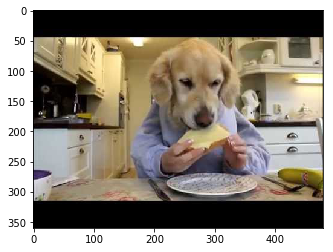

Hello dog! Your predicted breed is: Labrador_retriever


In [44]:
dog_breed_detector("C:/Users/sur216/Desktop/hqdefault.jpg")

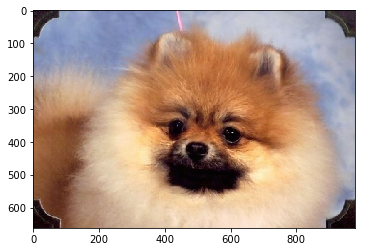

Hello dog! Your predicted breed is: Pomeranian


In [52]:
dog_breed_detector("C:/Users/sur216/Desktop/dog2.jpg")

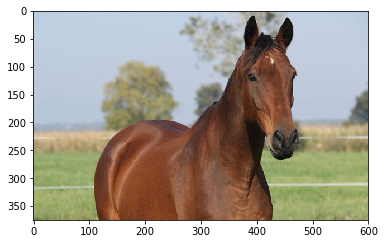

You are neither dog nor human!


In [53]:
dog_breed_detector("C:/Users/sur216/Desktop/horse.jpg")

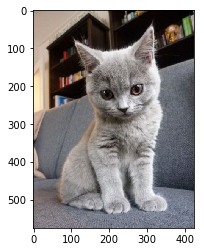

You are neither dog nor human!


In [63]:
dog_breed_detector("C:/Users/sur216/Desktop/cat.jpg")

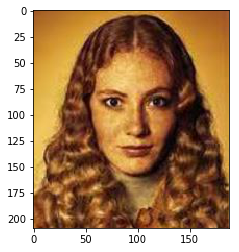

Hello human! you look similar to this dog breed:American_water_spaniel


In [54]:
dog_breed_detector("C:/Users/sur216/Desktop/human3.jpg")

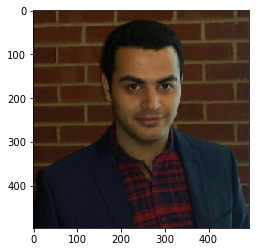

Hello human! you look similar to this dog breed:French_bulldog


In [56]:
dog_breed_detector("C:/Users/sur216/Desktop/me.jpg")

As we can see, our classifier CNN does a great job at predicting the images (although I strongly disagree that I look like a French_bulldog). There are many steps that one can take to improve this model: first, experiment with the dense layers that we added in the end, ResNet50 is supposed to predict way better than 83%. However, this would require one to have access to a GPU machine. Second, one can augment the data by adding rotation, scaling, and translation. Third, one can experiment with other pretrained models to see if any of them work better than ResNet50. 